### Use kernel conda_tensorflow2_p310

In [1]:
import os
import boto3
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import feature_column
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [2]:
print(tf.__version__)

2.11.0


In [3]:
%run ./read_file.ipynb

:: loading settings :: url = jar:file:/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ec2-user/.ivy2/cache
The jars for the packages stored in: /home/ec2-user/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9e04510a-f579-4674-aaa7-9ac9ab66a442;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 139ms :: artifacts dl 5ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	-----------------------------

23/04/17 20:35:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/17 20:35:49 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [4]:
# https://stackoverflow.com/questions/68036975/valueerror-shape-must-be-at-least-rank-3-but-is-rank-2-for-node-biasadd
# config for rank error in lstm
tf.config.threading.set_inter_op_parallelism_threads(16)
pd.set_option('display.max_columns', None)
tf.keras.backend.set_image_data_format("channels_last")

In [5]:
# Set Config
embedding_dim = 64
max_length = 6
sequence_length = 6
max_features = 10000
padding_type = 'post'
trunc_type = 'post'
training_portion = 0.8

# place to load models from
ckt_path_generator = 'saved_model/generator'
ckt_path_tokenizer = 'saved_model/tokenizer'
ckt_path_lstm = 'saved_model/lstm'
ckt_path_lstm_gen = 'saved_model/lstm_gen'
ckt_path_lstm_kf = 'saved_model/lstm_kf'
ckt_path_lstm_kf_gen = 'saved_model/lstm_kf_gen'

In [6]:
METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.BinaryCrossentropy(name='binary cross entropy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [7]:
# read generated data and update columns to match true data types
dsm = spark.read.parquet(*["s3a://sapient-bucket-trusted/prod/graph/motifs/gen_malicious/*"]) \
                .withColumn("mal_trace", col("mal_trace").cast("integer")) \
                .withColumn("malicious", col("malicious").cast("integer")) \
                .cache()

In [8]:
ds = spark.read.parquet(*["s3a://sapient-bucket-trusted/prod/graph/encoded/real/23Sep3/*"]).cache()

In [9]:
ds = ds.union(dsm).cache()

In [10]:
tot = ds.count()

In [11]:
ds.groupBy("mal_trace") \
    .count() \
    .withColumnRenamed('count', 'cnt_per_group') \
    .withColumn('perc_of_count_total', (col('cnt_per_group') / tot) * 100 ) \
    .sort("perc_of_count_total").show()

+---------+-------------+-------------------+
|mal_trace|cnt_per_group|perc_of_count_total|
+---------+-------------+-------------------+
|        1|       119909| 0.6901351009288557|
|        0|     17254805|  99.30986489907114|
+---------+-------------+-------------------+



In [12]:
def balance_dataframe(ds, ratio):
    # Calculate the number of malicious and non-malicious records
    malicious_count = ds.filter(col("mal_trace") == 1).count()
    non_malicious_count = ds.filter(col("mal_trace") == 0).count()

    target_non_malicious_count = malicious_count * ratio

    fraction_non_malicious = target_non_malicious_count / non_malicious_count
    
    # Sample the records based on the calculated fractions
    malicious_ds = ds.filter(col("mal_trace") == 1)
    non_malicious_ds = ds.filter(col("mal_trace") == 0).sample(fraction_non_malicious)

    # Combine the datasets
    balanced_ds = malicious_ds.union(non_malicious_ds)

    return balanced_ds

In [13]:
# Replace this with ratio of distribution, e.g. ratio of 2 non malicious records to 1 malicious record (1, 2, or 3)
ratio = 5

In [14]:
balanced_ds = balance_dataframe(ds, ratio)

In [15]:
balanced_ds.count()

720571

In [16]:
ds.unpersist()

DataFrame[Trace: bigint, mal_trace: int, malicious: int, event_sequence: array<string>]

In [17]:
balanced_ds.limit(5).toPandas()

,Trace,mal_trace,malicious,event_sequence
0,86473,1,1,"[01000000000100000100010000100000000000001, 10..."
1,98458,1,1,"[00010000000100000100010000100000000000001, 10..."
2,132328,1,1,"[00010000000100000100010000100000000000001, 10..."
3,8589966649,1,1,"[00010000000100000100010000100000000000001, 10..."
4,8589966809,1,1,"[00100000000100000100010000100000000000001, 10..."


In [18]:
ds_events = balanced_ds.select('event_sequence').rdd.flatMap(lambda x: x).collect()

In [19]:
ds_labels = balanced_ds.select('mal_trace').rdd.flatMap(lambda x: x).collect()

In [20]:
# tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000)
# tokenizer.fit_on_texts(ds_events)

In [21]:
# load saved tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()
with open(ckt_path_tokenizer, 'rb') as f:
    tokenizer = pickle.load(f)

In [22]:
# Get our training data word index
word_index = tokenizer.word_index
vocab_count = len(word_index)

In [23]:
# train test split data
train_set, validation_set, train_labels, validation_labels = train_test_split(ds_events, ds_labels,
                                                    stratify=ds_labels, 
                                                    test_size=0.2)

In [24]:
Counter(train_labels)

Counter({0: 480529, 1: 95927})

In [25]:
Counter(validation_labels)

Counter({0: 120133, 1: 23982})

In [26]:
train_sequences = tokenizer.texts_to_sequences(train_set)
train_padded = tf.keras.utils.pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [27]:
validation_sequences = tokenizer.texts_to_sequences(validation_set)
validation_padded = tf.keras.utils.pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [28]:
validation_sequences[0]

[6, 4, 3]

In [29]:
validation_padded[0]

array([6, 4, 3, 0, 0, 0], dtype=int32)

In [30]:
train_padded.shape

(576456, 6)

In [31]:
validation_padded.shape

(144115, 6)

In [32]:
train_ds = tf.reshape(train_padded, (len(train_padded),6,1))

In [33]:
validation_ds = tf.reshape(validation_padded, (len(validation_padded),6,1))

In [34]:
train_labels_ds = tf.ragged.constant(train_labels)
validation_labels_ds = tf.ragged.constant(validation_labels)

In [35]:
train_ds.shape

TensorShape([576456, 6, 1])

In [36]:
train_labels_ds.shape

TensorShape([576456])

In [37]:
validation_ds.shape

TensorShape([144115, 6, 1])

In [38]:
validation_labels_ds.shape

TensorShape([144115])

In [39]:
validation_ds[0]

<tf.Tensor: shape=(6, 1), dtype=int32, numpy=
array([[6],
       [4],
       [3],
       [0],
       [0],
       [0]], dtype=int32)>

In [40]:
def create_lstm():
    model = tf.keras.models.Sequential()
    model.add(layers.Embedding(vocab_count + 1, 16))
    model.add(keras.layers.LSTM(500, input_shape=(train_ds.shape[1], train_ds.shape[2]), return_sequences=True))
    model.add(keras.layers.LSTM(300, return_sequences=True))
    model.add(keras.layers.LSTM(200))
    model.add(keras.layers.Dense(train_ds.shape[2], activation='tanh'))
    model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=METRICS)
    return model

In [41]:
model = create_lstm()

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          1792      
                                                                 
 lstm (LSTM)                 (None, None, 500)         1034000   
                                                                 
 lstm_1 (LSTM)               (None, None, 300)         961200    
                                                                 
 lstm_2 (LSTM)               (None, 200)               400800    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 2,397,993
Trainable params: 2,397,993
Non-trainable params: 0
_________________________________________________________________


In [43]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ckt_path_lstm_gen,
                                                 save_weights_only=True,
                                                 verbose=1)

In [44]:
history = model.fit(
                x=train_ds,
                y=train_labels_ds,
                batch_size=128,
                epochs=11,
                verbose=1,
                validation_split=0.0,
                validation_data=(validation_ds, validation_labels_ds),
                shuffle=True,
                class_weight=None,
                sample_weight=None,
                initial_epoch=0,
                steps_per_epoch=None,
                validation_steps=None,
                validation_batch_size=None,
                validation_freq=1,
                max_queue_size=10,
                workers=1,
                use_multiprocessing=False,
                callbacks=[cp_callback]
                )

Epoch 1/11
4500/4504 [============================>.] - ETA: 0s - loss: 0.3398 - tp: 29338.0000 - fp: 15061.0000 - tn: 465079.0000 - fn: 66522.0000 - accuracy: 0.8584 - binary cross entropy: 0.3398 - precision: 0.6608 - recall: 0.3061 - auc: 0.8368 - prc: 0.5462
Epoch 1: saving model to saved_model/lstm_gen
4504/4504 [==============================] - 70s 14ms/step - loss: 0.3398 - tp: 29362.0000 - fp: 15072.0000 - tn: 465457.0000 - fn: 66565.0000 - accuracy: 0.8584 - binary cross entropy: 0.3398 - precision: 0.6608 - recall: 0.3061 - auc: 0.8368 - prc: 0.5462 - val_loss: 0.3002 - val_tp: 8829.0000 - val_fp: 2920.0000 - val_tn: 117213.0000 - val_fn: 15153.0000 - val_accuracy: 0.8746 - val_binary cross entropy: 0.3002 - val_precision: 0.7515 - val_recall: 0.3682 - val_auc: 0.8737 - val_prc: 0.6444
Epoch 2/11
4504/4504 [==============================] - ETA: 0s - loss: 0.2982 - tp: 41850.0000 - fp: 17585.0000 - tn: 462944.0000 - fn: 54077.0000 - accuracy: 0.8757 - binary cross entropy: 0

In [45]:
model.save('lstm_gen.h5')

In [46]:
def plot_graphs(history, metrics):
    fig, axs = plt.subplots(nrows = 2, ncols=3, figsize=(12, 6), layout="constrained")
    for ax, m in zip(axs.flat, metrics):
        ax.plot(history.history[m])
        ax.plot(history.history['val_'+ m])
        ax.set_title(f'{m}')
        # ax.xlabel("Epochs")
        # ax.ylabel(m)
        # ax.legend([m, 'val_'+ m])
        # ax.show()

In [47]:
metrics = ["accuracy", "loss", "prc", "recall", "auc", "precision"]

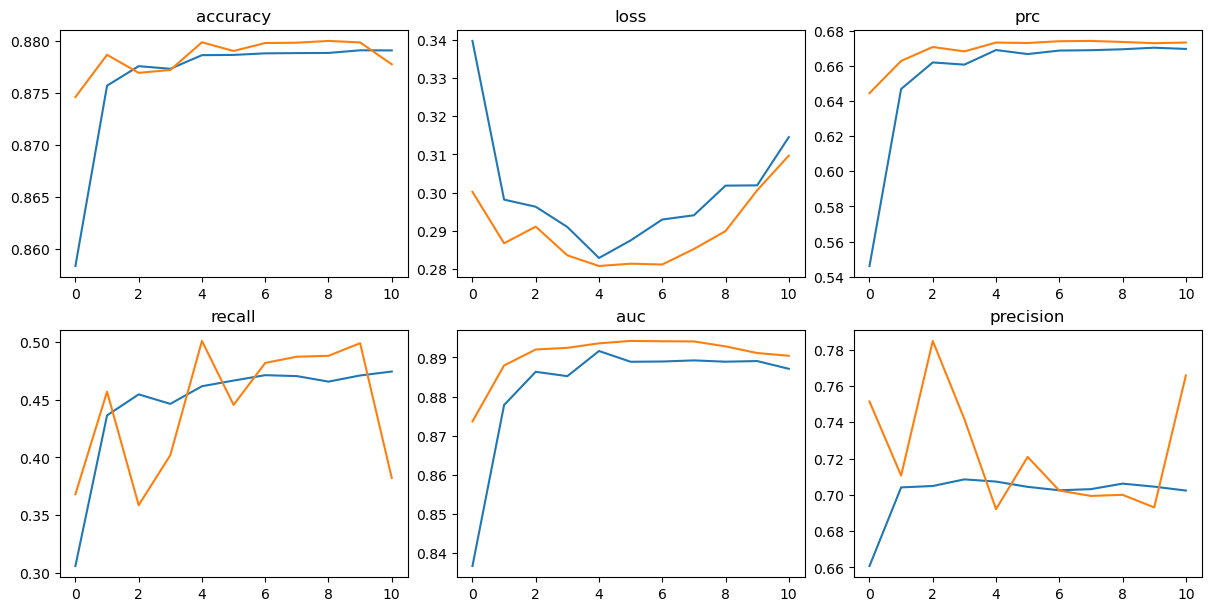

In [48]:
plot_graphs(history, metrics)

In [49]:
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model, ['benign','malicious'])

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


4504/4504 [==============================] - 16s 3ms/step


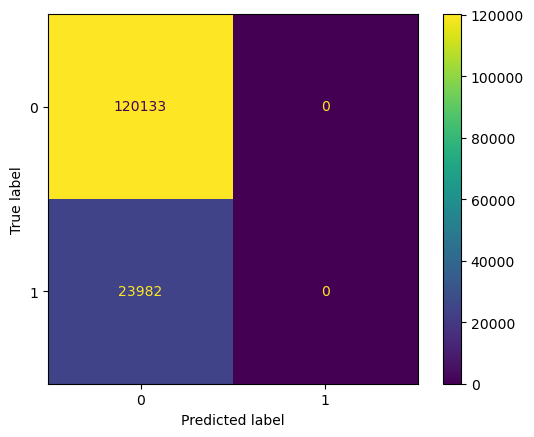

In [50]:
plot_confusion_matrix(estimator=classifier, X=validation_ds, y_true=validation_labels_ds)

In [51]:
# Create a basic model instance
model = create_lstm()
model.load_weights(ckt_path_lstm_gen)

In [52]:
# Re-evaluate the model
loss, tp, fp, tn, fn, accuracy, bin_ce, precision, recall, auc, prc = model.evaluate(validation_ds, validation_labels_ds, verbose=1)

4504/4504 [==============================] - 30s 6ms/step - loss: 0.3097 - tp: 18330.0000 - fp: 5606.0000 - tn: 234660.0000 - fn: 29634.0000 - accuracy: 0.8777 - binary cross entropy: 0.3097 - precision: 0.7658 - recall: 0.3822 - auc: 0.8904 - prc: 0.6732


In [53]:
print("Restored model, accuracy: {:5.2f}%".format(100 * accuracy))

Restored model, accuracy: 87.77%


In [54]:
pred = model.predict(validation_ds)

4504/4504 [==============================] - 16s 3ms/step


In [55]:
pred_class = np.argmax(pred, axis=-1)

In [56]:
pred_class = list(pred_class)

In [57]:
correct_len = len([i for i, j in zip(pred_class, validation_labels) if i == j])
total_len = len(pred_class) 
incorrect_len = total_len - correct_len

In [58]:
print(f'From a total of {total_len} traces, we correctly predicted {correct_len} and incorrectly predicted {incorrect_len}')

From a total of 144115 traces, we correctly predicted 120133 and incorrectly predicted 23982


In [59]:
# https://www.tensorflow.org/tutorials/video/video_classification
def plot_confusion_matrix(actual, predicted, labels):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of malicious trace recognition')
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [60]:
labels = ["benign", "malicious"]

In [61]:
Counter(pred_class)

Counter({0: 144115})

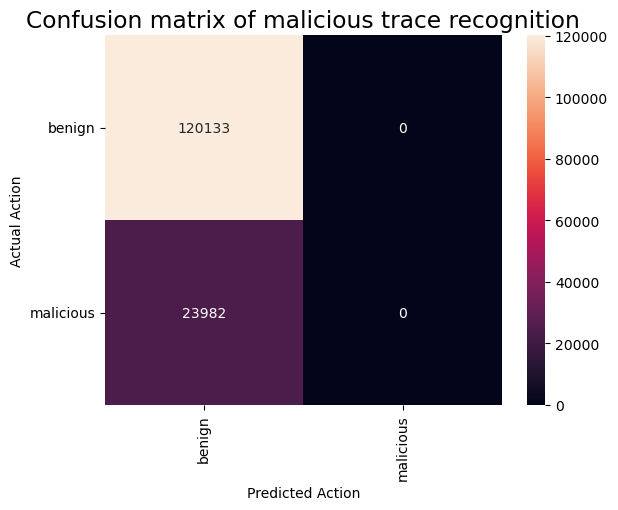

In [62]:
plot_confusion_matrix(validation_labels, pred_class, labels)

In [63]:
# labels for the data - 

In [64]:
# if theyre predicted to be malicious, add trace ids to a list of values 

In [65]:
# trace, malicious_trace

In [66]:
# 